In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg
from dba.DBA import performDBA

In [2]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [15]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
    pieces.append(signal[end:])

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    pieces_padded = np.array(pieces_padded)

    return pieces_padded

In [16]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()

    return [dis12/dis21, A0/A1]

(4718, 1000) (2822, 6)
(4718, 1000) (2822, 6)


0it [00:00, ?it/s]

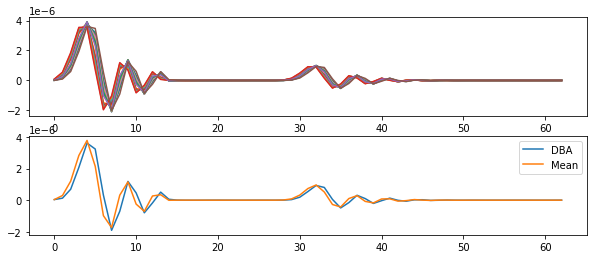

1it [00:01,  1.77s/it]

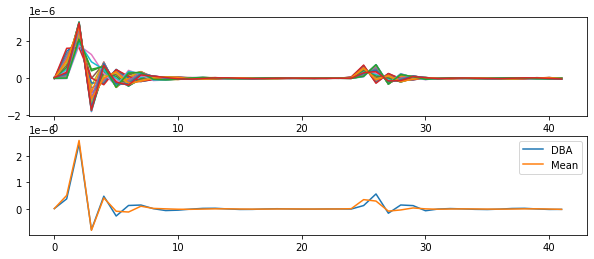

2it [00:03,  1.63s/it]

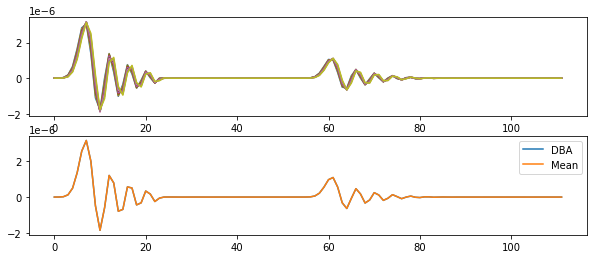

3it [00:05,  1.96s/it]

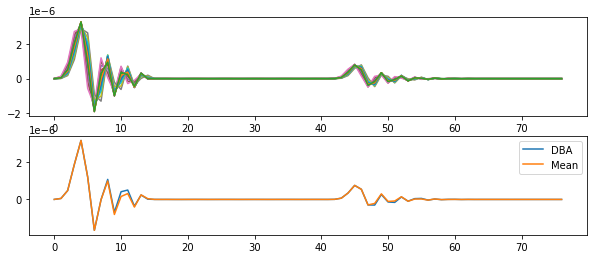

4it [00:07,  2.09s/it]

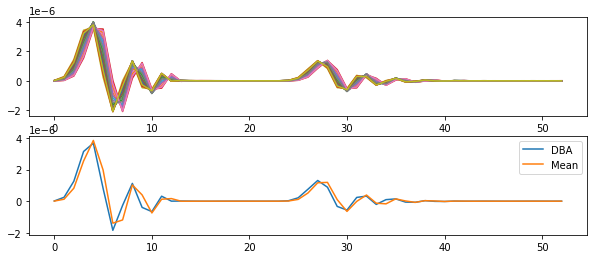

4it [00:10,  2.60s/it]
0it [00:00, ?it/s]

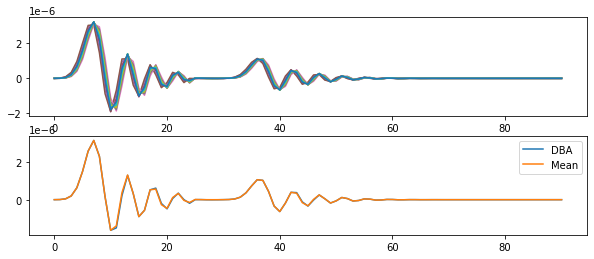

1it [00:03,  3.61s/it]

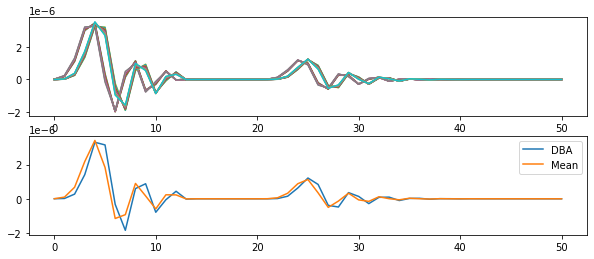

2it [00:06,  2.98s/it]

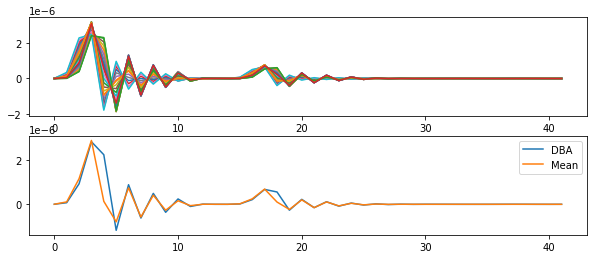

3it [00:08,  2.68s/it]

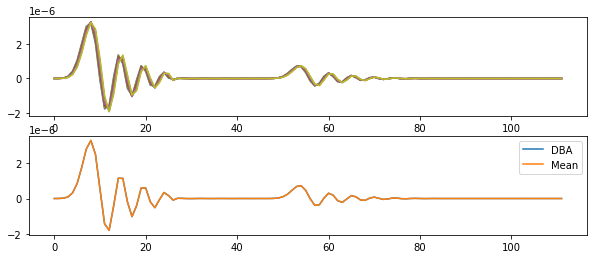

4it [00:11,  2.69s/it]

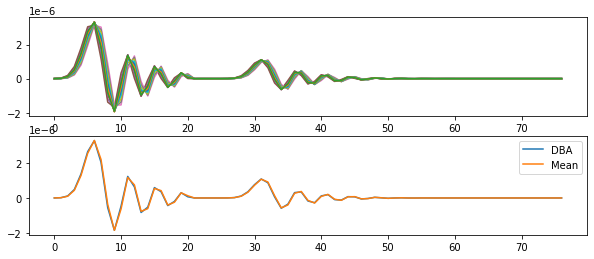

4it [00:13,  3.34s/it]


In [20]:
from tqdm import tqdm
# from dtw.dtw import dtw
# import random

if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    def extract_features(signals, labels, alpha, h, d, echo):
        Template_features = []
        idxs = []
        for cnt, signal in tqdm(enumerate(signals)):
            hr = labels[cnt, 2]
            large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
            pieces = segmentation(signal, large_peaks)

            template = performDBA(pieces)

            show = True
            if show:
                plt.subplots(2, 1, figsize=(10, 4))
                plt.subplot(2, 1, 1)
                for s in pieces:
                    plt.plot(range(0,len(s)), s)
                plt.subplot(2, 1, 2)
                plt.plot(range(0,len(template)), template, label='DBA')
                pieces_np = np.array(pieces)
                plt.plot(pieces_np.mean(0) , label='Mean')
                plt.legend()
                plt.show()

            features = get_features(template, h, d)
            if features is not None:
                idxs.append(cnt)
            Template_features.append(features)
            # break
            if cnt > echo:
                break
        return np.array(Template_features), np.array(idxs)

    echo = 3
    template_features_train, idxs_train = extract_features(signals_0_train, labels_0_train, 1, 0.1, 0.15, echo)
    template_features_test, idxs_test = extract_features(signals_0_test, labels_0_test, 1.2, 0.12, 0.12, echo)

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()


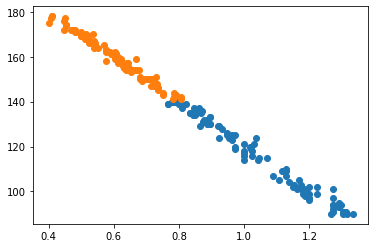

1.8614653543463846


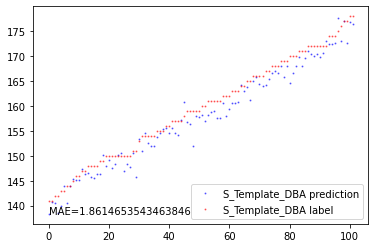

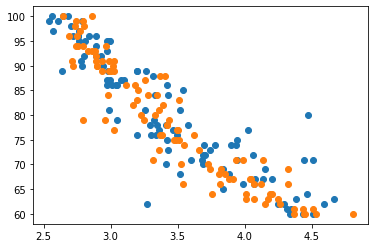

3.6398786177795426


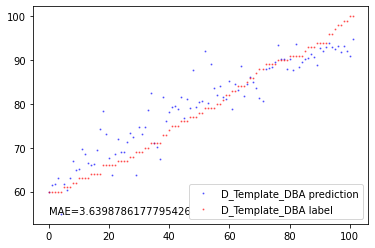

In [29]:
from sklearn.linear_model import LinearRegression as LR
# from Code.Tutorial.utils import plot_2vectors

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(template_features_train[:, 0],template_features_test[:, 0],labels_0_train[:echo+2, 4],labels_0_test[:echo+2, 4],'S_Template_DBA')
plot_plot(template_features_train[:, 1],template_features_test[:, 1],labels_0_train[:echo+2, 5],labels_0_test[:echo+2, 5],'D_Template_DBA')

In [23]:
template_features_train[:, 0].shape,template_features_test[:, 0].shape,labels_0_train[:11, 4].shape,labels_0_test[:11, 4].shape

((12,), (12,), (11,), (11,))